## Adaptive Label Smoothing 

___
$\def\abs#1{\left\lvert #1 \right\rvert}
\def\Set#1{\left\{ #1 \right\}}
\def\mc#1{\mathcal{#1}}
\def\M#1{\boldsymbol{#1}}
\def\R#1{\mathsf{#1}}
\def\RM#1{\boldsymbol{\mathsf{#1}}}
\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\d{\mathrm{\mathstrut d}}$

### Introduction

- Although deep learning models have achieved great success in practical applications, neural network training suffers from overfitting and is sensitive to the loss function that is minimized. 

- Label smoothing [Szegedy et al. 2016] is a regularization technique that only requires changing the loss function and does not require changing the design of the classifier itself. 

### Formulation

- Consider the classification problem. Let $\mathcal{X} \subset \mathbb{R}^d$ be the feature space from which the examples are drawn and let $\mathcal{Y} = [k] = \{1, · · · , k\}$ be the class labels. $\mathsf{X}\in\mathcal{X},\mathsf{Y}\in\mathcal{Y}$ are jointly distributed RVs. 

- Given i.i.d samples $\{\left(\mathsf{X}_{1}, \mathsf{Y}_{1}\right), \ldots,\left(\mathsf{X}_{N}, \mathsf{Y}_{N}\right)\}$, the typical cross-entropy loss is defined as:

$$
\begin{align}
\mathcal{L}:=&-E\left[\ln \hat{p}_{\theta}(\mathsf{Y} | \mathsf{X})\right]\\
\approx &-\frac{1}{N} \sum_{i} \ln \hat{p}_{\theta}\left(\mathsf{Y}_i | \mathsf{X}_i\right)
\end{align}
$$

Limitations:
- The trained model tends to overfit the data. The cross-entropy loss is minimized when the model assigns full probability (close to the hard target) to the training samples, which may not be the truth.

- The cross-entropy loss encourages the differences between the largest logit and all others to become large, which makes the model is sensitive to the perturbations of the inputs.

Instead of computing cross entropy with the hard targets, label smoothing technique constructs a new weighted mixture distribution with the uniform distribution $p_{\mathsf{U}}$:
$$
p_{\mathsf{Y}| \mathsf{X}}^{\prime}:=(1-\alpha) \cdot p_{\mathsf{Y} | \mathrm{X}}+\alpha \cdot p_{\mathrm{U}},
$$
where $\alpha$ is the smoothing factor.

Then the new loss function is the cross-entropy between the modified distribution and our model:
$$
\begin{align}
    \mathcal{L}_{l s}:=&-E\left[\sum_{y \in[k]} p_{\mathsf{Y}| \mathsf{X}}^{\prime}(y|\mathsf{X}) \ln \hat{p}_{\theta}(y | \mathsf{X})\right] \\
    =& -E\left[\sum_{y \in[k]} \left((1-\alpha) \cdot p_{\mathsf{Y} | \mathrm{X}}(y|\mathsf{X})+\alpha \cdot p_{\mathrm{U}}(y)\right) \ln \hat{p}_{\theta}(y | \mathsf{X})\right] \\
    =& -(1-\alpha)\cdot E\left[\ln \hat{p}_{\theta}(\mathsf{Y} | \mathsf{X})\right] - \alpha \cdot E\left[\sum_{y \in[k]} p_{\mathrm{U}}(y) \ln \hat{p}_{\theta}(y | \mathsf{X})\right] \\
    =& (1-\alpha)\cdot H(p,\hat{p}_{\theta}) +\alpha \cdot H(p_{\mathsf{U}},\hat{p}_{\theta})
\end{align}
$$

We can see that the modified cross entropy can be viewed as weighted sum of original loss and the cross entropy between the uniform distribution and our model. In this case, label smoothing may help reduce the dependency of our model and perticular training samples, and thereby improve the generalzation ability.

Limitations of Label Smoothing:
- $\alpha$ is chosen to be a constant for all training samples. However, the model may not overfit on some of these training samples.
- The optimal solution is $\hat{p}_{\theta}=p'_{\mathsf{Y}|\mathsf{X}}$, which will lead to a biased probabilistic model.

We propose to adaptively choose $\alpha$ based on the output of the probability model:
$$
    \begin{align}
    \alpha &:= \alpha(\hat{p}_{\theta}(\mathsf{Y}|\mathsf{X})) \qquad \text{where},\notag\\
    \alpha(q) &:= \left\{
    	 \begin{array}{ll}
    	 -\frac{\alpha_{0}}{\tau}q+\alpha_{0}, &
    	 q\in[0,\tau], \\
    	 0, & q\in[\tau,1-\tau], \\
    	 \frac{\alpha_{0}}{\tau}q+\frac{\tau-1}{\tau}\alpha_{0}, & q\in[1-\tau,1]
    	 \end{array} \notag
    \right.
    \end{align}
$$

This approach can avoid unnecessary bias by applying label smoothing only to samples that require smoothing. 

## Example

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.datasets import make_circles, make_moons
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.utils import *

In [2]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

niters = 5000
sample_size = 100
noise = 0.05
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = Net(input_size=2, hidden_size=100)
alpha = 1
ce_loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
if cuda:
    model.to(device)

x, y = make_circles(n_samples=sample_size, factor=.3, noise=noise)
# x, y = make_moons(n_samples=sample_size, noise=noise)

X = torch.Tensor(x).to(device)
Y = torch.Tensor(y).to(device)

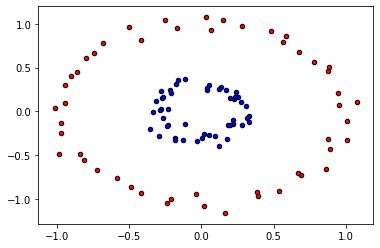

In [3]:
reds = y == 0
blues = y == 1

plt.scatter(x[reds, 0], x[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(x[blues, 0], x[blues, 1], c="blue",
            s=20, edgecolor='k')

In [4]:
# cross-entropy loss
for i in range(niters):
    batch_X, batch_Y = resample(X, Y, batch_size=100, replace=True)
    optimizer.zero_grad()
    pred_Y = model(batch_X)
    acc = accuracy(batch_Y.reshape(-1,1), pred_Y)
    loss = ce_loss(pred_Y, batch_Y.reshape(-1,1))
    loss.backward()
    optimizer.step()
    if i%1000==0:
        print("Iternation: %d, loss: %f, acc: %f"%(i, loss.item(), acc))

Iternation: 0, loss: 0.693179, acc: 0.490000
Iternation: 1000, loss: 0.002068, acc: 1.000000
Iternation: 2000, loss: 0.000258, acc: 1.000000
Iternation: 3000, loss: 0.000067, acc: 1.000000
Iternation: 4000, loss: 0.000025, acc: 1.000000


In [5]:
N = 100
xx = np.linspace(-1.,1.,N)
x1, x2 = np.meshgrid(xx,xx)

In [6]:
model.to('cpu')
pred_ce = model(torch.Tensor([x1.ravel(), x2.ravel()]).T).reshape(x1.shape).detach()

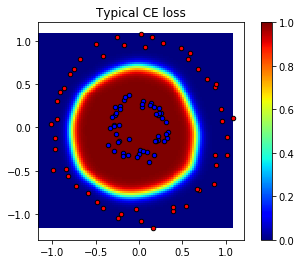

In [7]:
from matplotlib import cm as CM
extent = [x.min(), x.max(), x.min(), x.max()]
plt.imshow(pred_ce, extent=extent, origin='lower', cmap=CM.jet)
cb = plt.colorbar()
plt.scatter(x[reds, 0], x[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(x[blues, 0], x[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title('Typical CE loss')
plt.show()

In [8]:
def smooth_ce_loss(pre_label, true_label, smoothing, num_classes):
    new_labels = (1.0 - smoothing) * true_label + smoothing / num_classes
    return torch.nn.BCELoss()(pre_label, new_labels)

model = Net(input_size=2, hidden_size=100)
alpha = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
if cuda:
    model.to(device)

In [9]:
for i in range(niters):
    batch_X, batch_Y = resample(X, Y, batch_size=100)
    optimizer.zero_grad()
    pred_Y = model(batch_X)
    acc = accuracy(batch_Y.reshape(-1,1), pred_Y)
    loss = smooth_ce_loss(pred_Y, batch_Y.reshape(-1,1), 0.1, 2)
    loss.backward()
    optimizer.step()
    if i%1000==0:
        print("Iternation: %d, loss: %f, acc: %f"%(i, loss.item(), acc))

Iternation: 0, loss: 0.693148, acc: 0.500000
Iternation: 1000, loss: 0.202095, acc: 1.000000
Iternation: 2000, loss: 0.201851, acc: 1.000000
Iternation: 3000, loss: 0.201698, acc: 1.000000
Iternation: 4000, loss: 0.201581, acc: 1.000000


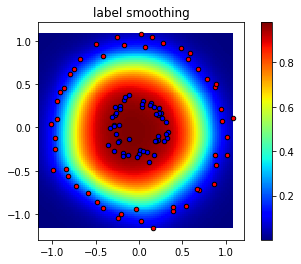

In [10]:
model.to('cpu')
pred_ls = model(torch.Tensor([x1.ravel(), x2.ravel()]).T).reshape(x1.shape).detach()
from matplotlib import cm as CM
plt.imshow(pred_ls, extent=extent, origin='lower', cmap=CM.jet)
cb = plt.colorbar()
plt.scatter(x[reds, 0], x[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(x[blues, 0], x[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title('label smoothing')
plt.show()

We can see from this example that, although the typical cross-entropy loss can achieve perfect accuracy in the training set, the decision boundary ($\hat{p}_{\theta}(1|x)=\frac{1}{2})$ is quite steep. After softening the hard target with label smoothing, the trained model can provide more reliable and smoother predictions around the decision boundary.

In [11]:
def acti_func(x, a, b, c):
    # a is \alpha_0, b is \tau and c is 1-\tau in the paper
    alpha = torch.zeros_like(x)
    x_cpu = x.cpu()
    alpha[np.where(x_cpu.cpu()<=b)] = - a*x[np.where(x_cpu<=b)]/b + a
    alpha[np.where((x_cpu>b) & (x_cpu<c))] = 0
    alpha[np.where(x_cpu>=c)] = a*x[np.where(x_cpu>=c)]/(1-c) + a*c/(c-1)
    return alpha

In [12]:
model = Net(input_size=2, hidden_size=100)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
if cuda:
    model.to(device)
    
a, b, c = 0.01, 1e-3, 1-1e-3
for i in range(niters):
    batch_X, batch_Y = resample(X, Y, batch_size=100)
    optimizer.zero_grad()
    pred_Y = model(batch_X)
    conf = acti_func(pred_Y, a, b, c)
    acc = accuracy(batch_Y.reshape(-1,1), pred_Y)
    loss = smooth_ce_loss(pred_Y, batch_Y.reshape(-1,1), conf.detach(), 2)
    loss.backward()
    optimizer.step()
    if i%1000==0:
        print("Iternation: %d, loss: %f, acc: %f"%(i, loss.item(), acc))

Iternation: 0, loss: 0.693146, acc: 0.490000
Iternation: 1000, loss: 0.010217, acc: 1.000000
Iternation: 2000, loss: 0.010289, acc: 1.000000
Iternation: 3000, loss: 0.010068, acc: 1.000000
Iternation: 4000, loss: 0.010040, acc: 1.000000


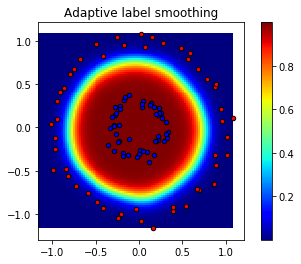

In [13]:
model.to('cpu')
pred_ls = model(torch.Tensor([x1.ravel(), x2.ravel()]).T).reshape(x1.shape).detach()
from matplotlib import cm as CM
plt.imshow(pred_ls, extent=extent, origin='lower', cmap=CM.jet)
cb = plt.colorbar()
plt.scatter(x[reds, 0], x[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(x[blues, 0], x[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title('Adaptive label smoothing')
plt.show()

## Adaptive Label Smoothing for Mutual Information Estimation

In typical classifier-based MI estimator, we define a mixture distribution $p_{\tilde{\R{X}}\tilde{\R{Y}}|\R{C}}$, where $\R{C}\in \{0,1\}$:
$$
\begin{equation}
    p_{\tilde{\R{X}}\tilde{\R{Y}}|\R{C}=1}=p_{\R{X}\R{Y}} \quad\text{and}\quad
    p_{\tilde{\R{X}}\tilde{\R{Y}}|\R{C}=0}=p_{\R{X}}p_{\R{Y}}.
\end{equation}
$$

Then we can estimate the density ratio as:
$$
\begin{align}
    r(x,y)=\frac{p_{\R{X}\R{Y}}(x,y)}{p_{\R{X}}(x)p_{\R{Y}}(y)}=\frac{p_{\tilde{\R{X}}\tilde{\R{Y}}|\R{C}}(x,y|1)}{p_{\tilde{\R{X}}\tilde{\R{Y}}|\R{C}}(x,y|0)}=
	 \frac{p_{\R{C}}(0)}{p_{\R{C}}(1)} \cdot
	 \frac{p_{\R{C}|\tilde{\R{X}}\tilde{\R{Y}}}(1|x,y)}{p_{\R{C}|\tilde{\R{X}}\tilde{\R{Y}}}(0|x,y)}
\end{align}
$$

Therefore, we can train a classifier to distinguish between the positive (from $p_{\R{X}\R{Y}}$) and negative samples $p_{\R{X}}p_{\R{Y}}$, and estimate the mutual information by
$$
\begin{align}
I(\RX\wedge\RY)
    &\approx \frac{1}{\tilde{N}}\sum_i \log r(\tilde{\R{X}}_i,\tilde{\R{Y}}_i) \notag\\
    &\approx \log \frac{p_{\R{C}}(0)}{p_{\R{C}}(1)} + \frac{1}{\tilde{N}}\sum_i \log\frac{\hat{p}_{\theta}(1|\R{X}_i,\R{Y}_i)}{\hat{p}_{\theta}(0|\R{X}_i,\R{Y}_i)}
\end{align}
$$

However, the trained classifier tends to be overly confident on its predictions, which is known as overfitting problem and may lead to numerical issue and infinite MI estimate. 

We can apply the adaptive label smoothing to solve the problem.